# PU learning techniques applied to artificial data

## "Blobs" data set

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
%matplotlib inline                  
plt.rcParams['figure.figsize'] = 7,7   # graph dimensions
plt.rcParams['font.size'] = 14         # graph font size

In [2]:
# Create the data set
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y > 1).astype(int)  # Convert the original labels [0,1,2,3] to [0,1]
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

In [3]:
# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

6000 data points and 2 features
3000 positive out of 6000 total


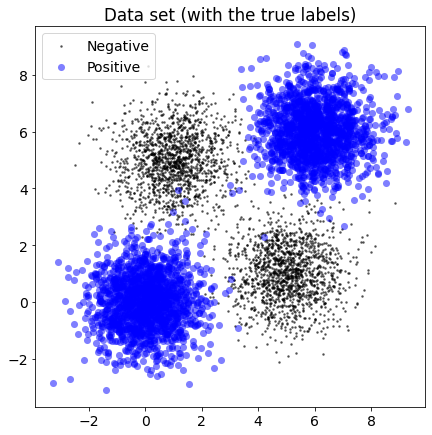

In [4]:
# Plot the data set with the true labels
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Negative'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (with the true labels)')
plt.show()

In [5]:
# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2700
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [6]:
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

300 positive out of 6000 total


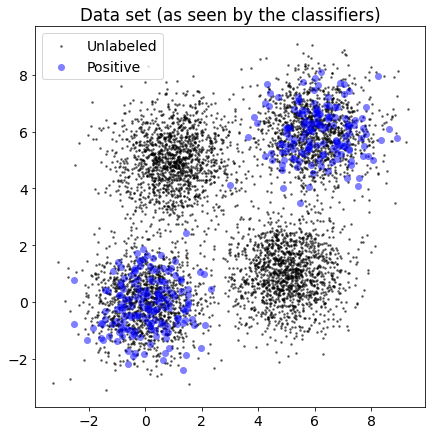

In [7]:
# Plot the data set, as the models will see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

## Standard classifier

In [8]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

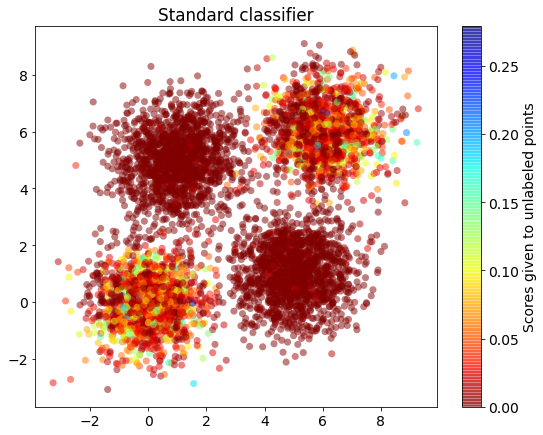

In [9]:
# Visualize this approach's results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

## Bagging

### Using `BaggingPuClassifier`

In [10]:
from pulearn import BaggingPuClassifier
from sklearn.tree import DecisionTreeClassifier
bc = BaggingPuClassifier(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

/Users/shaypalachy/.pyenv/versions/3.8.5/envs/py3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


BaggingPuClassifier(estimator=DecisionTreeClassifier(), max_samples=300,
                    n_estimators=1000, n_jobs=-1)

In [11]:
results['output_bag'] = bc.oob_decision_function_[:,1]

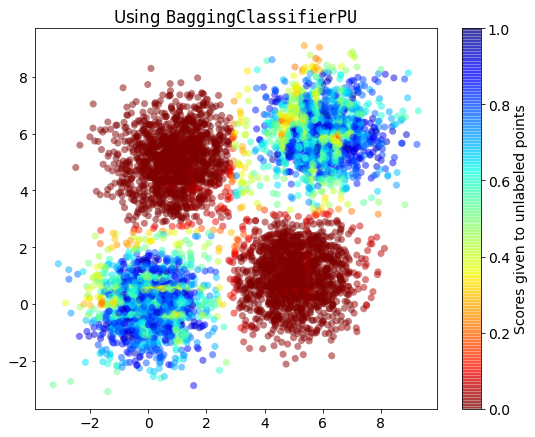

In [12]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

## Comparison of approaches

In [13]:
# For each data point, calculate the average score from the three approaches
results['output_all'] = results[[
    'output_std', 'output_bag',
]].mean(axis = 1)

In [14]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )
    

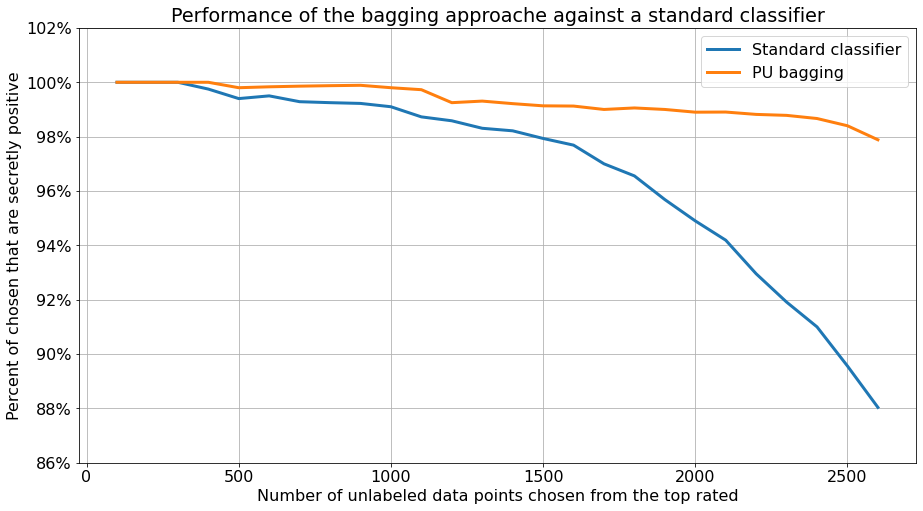

In [15]:
# Performance graphing
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'PU bagging', 
    'Two-step approach', 
    'Average score'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the bagging approache against a standard classifier')
plt.grid()
plt.show()